<a href="https://colab.research.google.com/github/harnalashok/DataVisualization/blob/master/umap_tutorial_on_100_dimensional_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer


from sklearn.pipeline import Pipeline, make_pipeline

import warnings
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

# Introduction

No matter how powerful machine learning models are, they can't quite beat the feeling you get during those "Aha!" moments of exploring data through rich visuals. But, there are so many histograms, scatterplots, heatmaps you can create before you say, "this is really getting old."

In those moments, you need something that reminds you of how amazing and mesmerizing data can be. You need to get inspiration from masterpiece visuals like at FlowingData or relevant subreddits, but you don't have to go that far. Recently, I have been fortunate to come across UMAP — a Python package to visualize and cluster high-dimensional data in breathtakingly beautiful ways. It was just what I needed to remember why I got into learning data science two years ago.

Today, we will learn how to analyze multi-dimensional datasets by projecting them to 2D using Uniform Manifold Approximation & Projection (UMAP) package through visuals like below:

<p float="left">
  <img src="https://miro.medium.com/max/1250/1*OMXhwgFxgwn5fLEkGrV_Pw.png" width="300" height="300"/>
  <img src="https://miro.medium.com/max/3750/1*GEeKKJET7WzzrGcWhL3H-A.png" width="300" height="300"/>
  <img src="https://miro.medium.com/max/1250/1*rlfn-CugxKhmZ8G7sLJQJQ.png" width="300" height="300"/> 
</p>

# What is UMAP?

UMAP is a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) algorithm and a powerful data analysis tool.

It is similar to PCA (Principal Component Analysis) in terms of speed and resembles tSNE to reduce dimensionality while preserving as much information of the dataset as possible. Before the UMAP algorithm was introduced in 2018, PCA and tSNE had two most significant flaws:

1) PCA was very fast at the cost of losing finer details of the data after the reduction
2) tSNE was extremely slow even though it preserves the underlying structure of the data.

We will talk more about these differences later. Now, it is time to get the first taste of UMAP, and we will immediately start with a challenging dataset:

In [ ]:
tps = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv").drop("id", axis=1)
tps.head().sample(10, axis=1)

,f7,f49,f74,f66,f5,claim,f82,f107,f38,f117
0,135.12000,0.34193,41299000000.00000,72.17800,0.28915,1,123180000000.00000,0.00107,3.53920,140.10000
1,1721.90000,0.01274,2242300000.00000,78.33900,0.45970,0,183240000000.00000,0.04928,1.46800,1861.00000
2,2298.00000,-0.67669,5144900000000.00000,36.99200,0.45948,1,101330000000.00000,0.00167,1.35610,3838.20000
3,112.51000,-1.18980,10770000000.00000,103.97000,0.51947,1,18354000000.00000,-0.00279,2.95530,4889.10000
4,2538.90000,-1.08960,286960000000.00000,73.73700,0.34490,1,38252000000.00000,0.00221,1.33510,NaN


In [ ]:
tps.shape

(957919, 119)

The Kaggle TPS September dataset contains ~1M rows and ~120 features with a binary target. They are all numerical, and we are pretty helpless in performing proper EDA on this dataset. Our options are limited to only printing summary statistics and plotting histograms of each feature.

Let's see what UMAP can do for us. Before using it, we will sample the dataset to avoid overplotting and fill in the missing values:

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# Sample the data - 100k
tps_sample = tps.sample(100000)
X, y = tps_sample.drop("claim", axis=1), tps_sample[["claim"]].values.flatten()

# Preprocess
pipe = make_pipeline(SimpleImputer(strategy="mean"))
X = pipe.fit_transform(X.copy())

Here, the target represents whether or not a client claims their insurance.

After [installing](https://umap-learn.readthedocs.io/en/latest/#:~:text=install%20umap-learn-,User%20Guide%20/%20Tutorial%3A,-How%20to%20Use) and importing UMAP, we initialize the manifold algorithm and fit it to `X`, `y` in the familiar Sklearn `fit/transform` pattern:

In [ ]:
%%time

import umap  # pip install umap-learn

manifold = umap.UMAP().fit(X, y)
X_reduced = manifold.transform(X)

2021-09-25 04:21:14.390367: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-25 04:21:14.390487: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


CPU times: user 7min 28s, sys: 50.2 s, total: 8min 18s
Wall time: 2min 44s


In [ ]:
X_reduced.shape

(100000, 2)

By default, UMAP projects the data into two components (2D). Let's create a scatterplot colored by the target class:

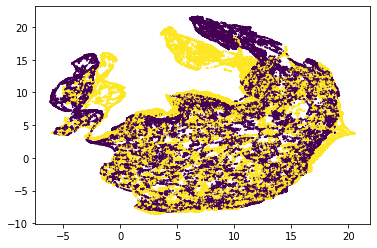

In [ ]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=0.5);

Even though it is fun to look at, the plot does not show any clear patterns. It is because we didn't scale the features before fitting UMAP. The algorithm uses distance metrics to group similar data points, and features with higher scales bias such calculations.

So, we will choose Quantile Transformer to scale the features based on their quantiles and median. This scaling method suits the dataset better since it contains many skewed and bimodal features:

In [ ]:
%%time

from sklearn.preprocessing import QuantileTransformer

# Preprocess again
pipe = make_pipeline(SimpleImputer(strategy="mean"), QuantileTransformer())
X = pipe.fit_transform(X.copy())

# Fit UMAP to processed data
manifold = umap.UMAP().fit(X, y)
X_reduced_2 = manifold.transform(X)

CPU times: user 4min 49s, sys: 10 s, total: 4min 59s
Wall time: 1min 24s


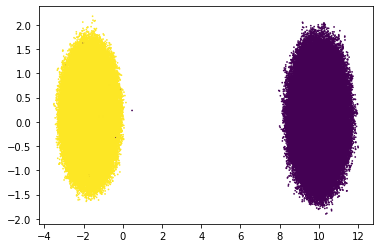

In [ ]:
# Plot the results
plt.scatter(X_reduced_2[:, 0], X_reduced_2[:, 1], c=y, s=0.5);

Now, we are talking! UMAP managed to capture the hidden distinction between the target classes perfectly. We can also see some outliers (the dot around the yellow blob). The dataset was not so challenging after all.

But, this plot is in no way close to what I have shown you. It is still overplotted to see structural patterns within each cluster. To take this to the next level, we will use the default UMAP visualization package with many more features. And we will need a better dataset.

# Better visualization with UMAP

This section will analyze the Kaggle TPS May competition data that categorizes ~200k eCommerce listings based on ~75 numeric qualities. Let's import it and take a quick look:

In [ ]:
tps_june = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv")

X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

X.head().sample(10, axis=1)

,feature_8,feature_59,feature_29,feature_51,feature_43,feature_72,feature_14,feature_27,feature_31,feature_18
0,7,0,0,0,9,2,1,0,1,3
1,0,0,0,0,2,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0
3,0,0,1,10,0,4,0,37,13,22
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(200000, 76)

In [ ]:
np.unique(y)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

The target contains nine classes.

As before, we will scale all features, but this time with a straightforward log transform. Then, we fit the UMAP manifold:

In [ ]:
import umap
from sklearn.preprocessing import PowerTransformer

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

In [ ]:
%%time

manifold = umap.UMAP().fit(X, y_encoded)

CPU times: user 9min 43s, sys: 35.8 s, total: 10min 18s
Wall time: 2min 47s


After the fit is done, we will import the `umap.plot` package (installed separately) and plot a point cloud:

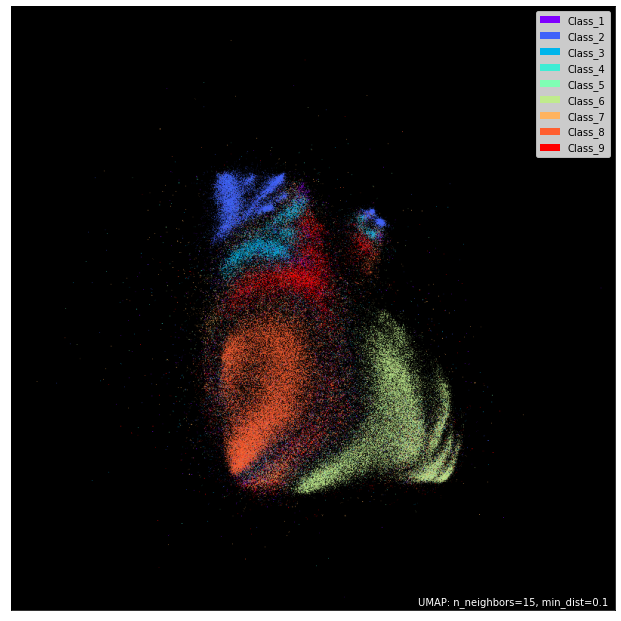

In [ ]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(manifold, labels=y, theme="fire");

Doesn't it resemble a nebula from space? We can distinctly see that Class 8 dominates the space and is clustered around the center. Class 6 is also clearly distinguished from the rest. We see half a circle of mixed data points around class 8. Regarding the singleton data points, they may be classified as outliers.

> A note on visualization above - we are simply passing the fitted manifold (not transformed data!) to the `points` function and specifying the labels for color encoding. I have also chosen the `fire` as a dark theme.

You can also create connectivity plots with `umap.plot.connectivity` for diagnostics purposes and to better understand the manifold structure. Do note that creating these plots is time-consuming and computation/memory-heavy.

<p float="left">
  <img src="https://miro.medium.com/max/1250/1*OMXhwgFxgwn5fLEkGrV_Pw.png" width="300" height="300"/>
  <img src="https://miro.medium.com/max/1250/1*rlfn-CugxKhmZ8G7sLJQJQ.png" width="300" height="300"/> 
</p>

You can learn more about UMAP visualizations from [this section](https://umap-learn.readthedocs.io/en/latest/plotting.html) of the documentation.

# Most important parameters of UMAP

The underlying reduction algorithm has many parameters that can significantly impact the manifold and hence, the visuals. The four most important ones are:
- `n_components`
- `n_neighbors`
- `min_dist`
- `metric`

As you might have guessed, `n_components` controls the number of dimensions after the projection. The default is 2 for its ease of visualization. However, for datasets with more than 100 features, 2D may not be enough to preserve the underlying topological structure of the data fully. I recommend trying values between 2-20 at steps of 5 and evaluate different baseline models to see the change in accuracy.

Next, we have `n_neighbors`. It controls the area of the local neighborhood UMAP looks at for each sample when building the manifold. Smaller values narrow the focus to local structure, taking into account peculiarities and small patterns, potentially losing the big picture.

Higher values to `n_neighbors` give more flexibility and allows UMAP to focus on a broader "view" of the data in the corresponding dimension. This, of course, comes at the cost of losing the finer details of the structure. The default value for this parameter is 15.

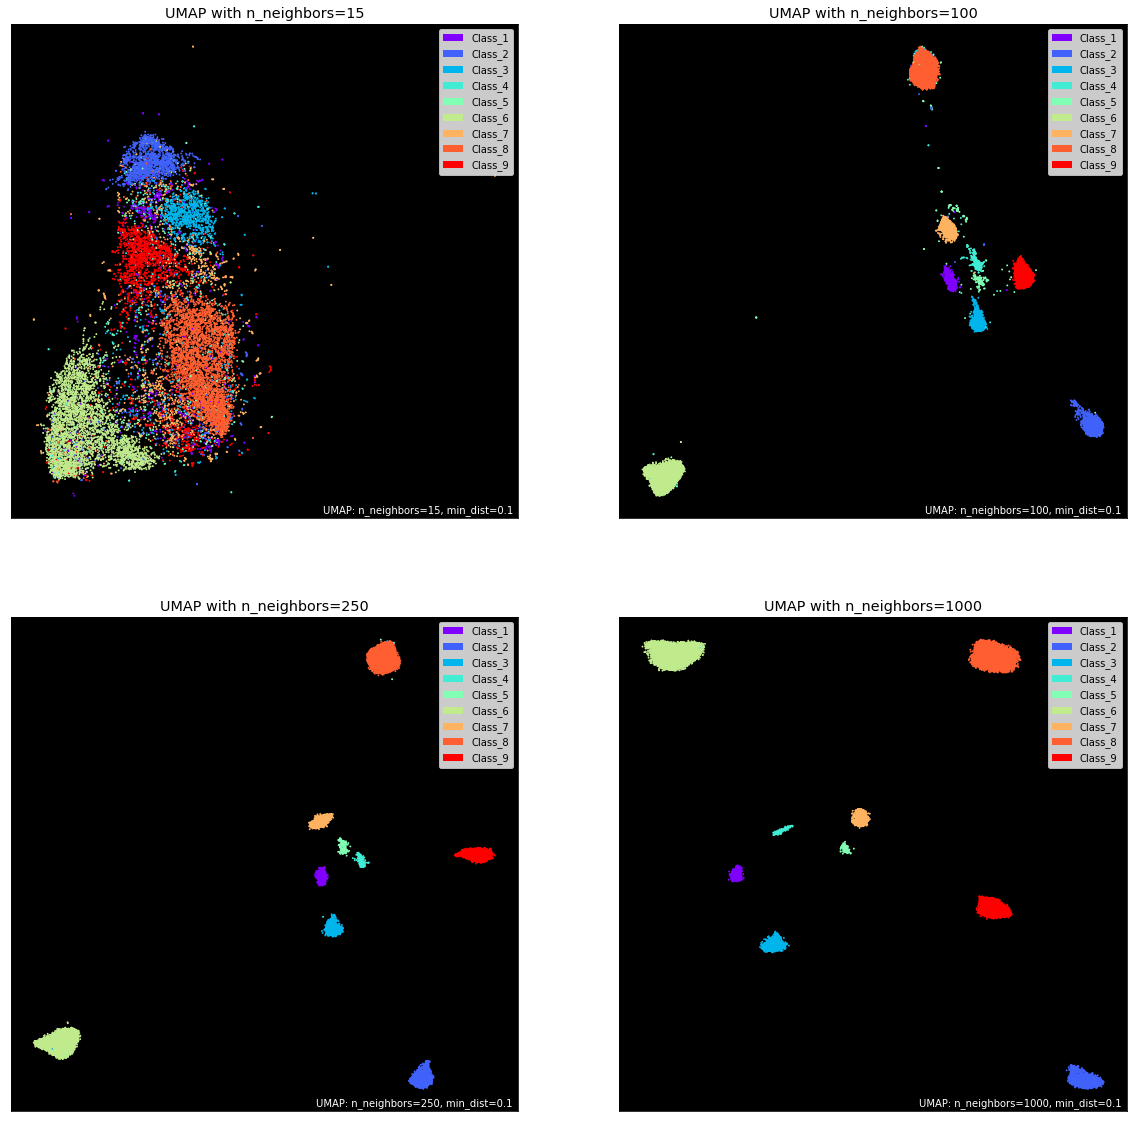

In [ ]:
n_neighbors = [15, 100, 250, 1000]

tps_june = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv").sample(15000)

X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for ax, n in zip(ax.flatten(), n_neighbors):
    manifold = umap.UMAP(n_neighbors=n, random_state=1121218)
    manifold.fit(X, y_encoded)
    umap.plot.points(manifold, labels=y, ax=ax, theme="fire")
    ax.set_title(f"UMAP with n_neighbors={n}", fontsize="x-large")


fig.savefig("multiple_neighbors.png", dpi=300);

Another critical parameter is `min_dist` which controls the literal distance between data points. You can tweak the default value of 0.1 to control the tightness of distinct point clouds. Lower values will result in clumpier embeddings, allowing you to see individual clusters more easily. This may be useful during clustering. In contrast, values close to 1 give points more breathing room and enable you to see the broader topological structure.

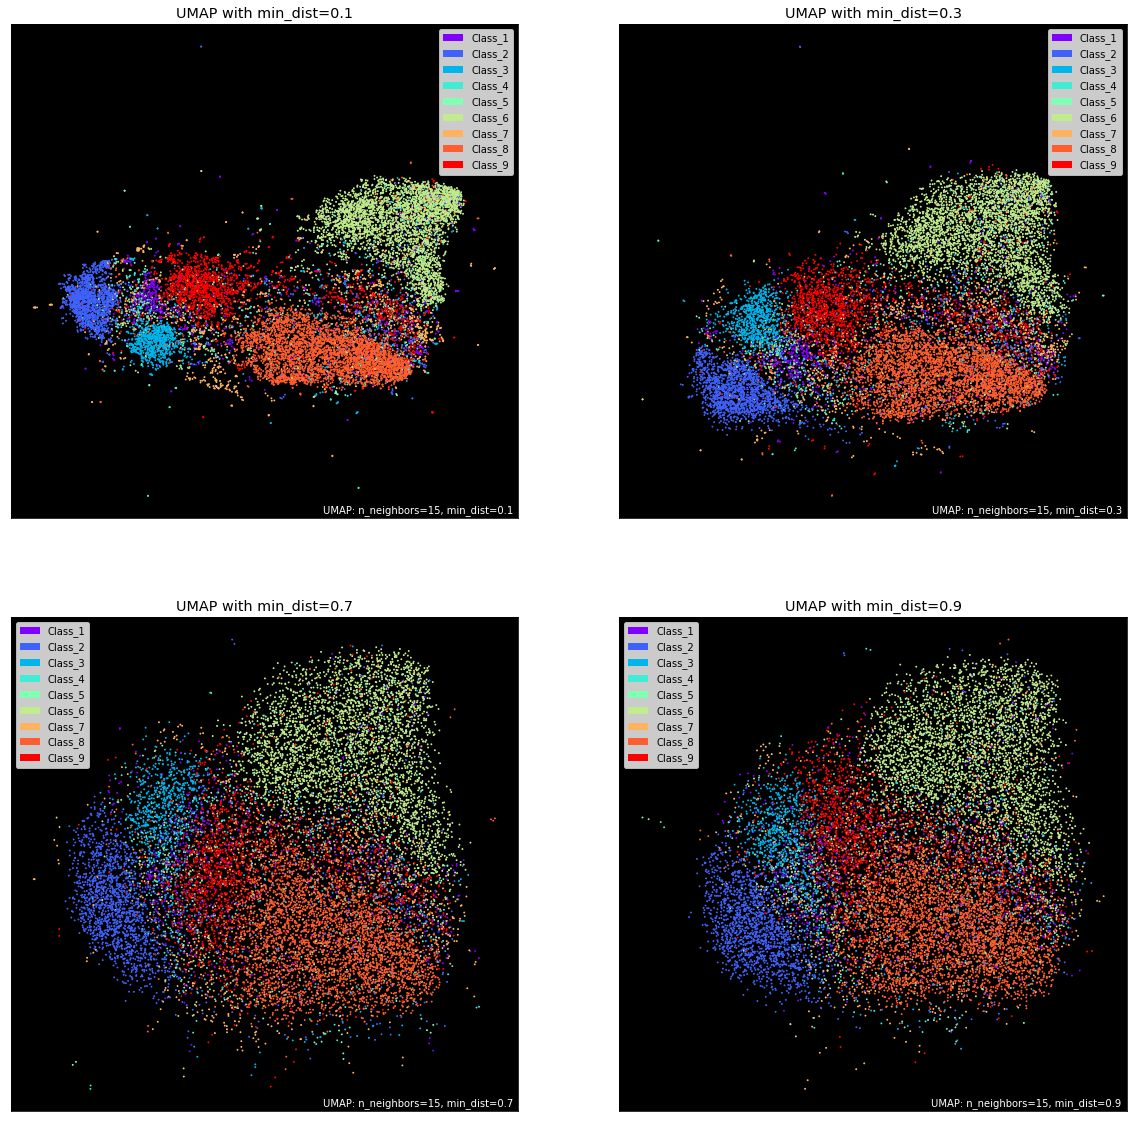

In [ ]:
import umap.plot  # pip install umap-learn[plot]
from sklearn.preprocessing import PowerTransformer
distances = [0.1, 0.3, 0.7, 0.9]

tps_june = pd.read_csv("../input/tabular-playground-series-jun-2021/train.csv").sample(15000)

X, y = tps_june.drop("target", axis=1), tps_june[["target"]].values.flatten()

# Scale
pipe = make_pipeline(PowerTransformer())
X = pipe.fit_transform(X.copy())

# Encode the target to numeric
y_encoded = pd.factorize(y)[0]

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for ax, n in zip(ax.flatten(), distances):
    manifold = umap.UMAP(min_dist=n, random_state=1121218)
    manifold.fit(X, y_encoded)
    umap.plot.points(manifold, labels=y, ax=ax, theme="fire")
    ax.set_title(f"UMAP with min_dist={n}", fontsize="x-large")


fig.savefig("multiple_distances.png", dpi=300);


`metric` represents the formula to calculate the distance between points. The default is `euclidean` but you can choose among many others, including `manhattan`, `minkowski` and `chebyshev`.

# Best practices of using UMAP

First consideration while using UMAP is the RAM consumption. Under the hood, UMAP consumes a lot of memory, especially during fitting and creating diagrams like connectivity plots. I suggest running UMAP on a machine with at least 16GB of RAM.

For example, even the 200k-row dataset in the plotting section consumed ~18GB of RAM when creating the connectivity plot. The documentation suggests setting `low_memory` to True as a possible fix. Additionally, I recommend reducing the memory usage of the dataset by casting each column to the smallest subtype possible using NumPy. I have discussed dealing with out-of-memory issues at length in a previous article ([link](https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd?source=your_stories_page-------------------------------------)).

Also, don't forget to transform/scale numerical features as they tend to have different scales by default. I suggest QuantileTransformer for crazy distributions like bimodals, trimodals, etc. PowerTransformer works best for skewed features. Whichever transformer you choose, the goal is always to make features as normally distributed as possible.

# Summary

Today, we have covered the basics of UMAP and learned only a thin slice of what it can do. For further reading, I suggest checking out the documentation of the package. There, you will see different use cases of UMAP and how it is used by tech giants like Google in various projects.
There are also dedicated sections for comparing UMAP to other dimensionality reduction algorithms. For a math enthusiast, you can also read how UMAP works and proofs of its formulas. Thank you for reading!